************************************************************************************************************************************************************************************************************************************************************************************************************


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Date
2021-08-03    419.371094
2021-08-04    417.308197
2021-08-05    419.950989
2021-08-06    420.644958
2021-08-09    420.302734
                 ...    
2024-12-27    595.010010
2024-12-30    588.219971
2024-12-31    586.080017
2025-01-02    584.640015
2025-01-03    591.950012
Name: SPY_Adj_Close, Length: 861, dtype: float64
************************************************************************************************************************************************************************************************************************************************************************************************************
Fetching SPY data...
Processing data...
Training model...
Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0658 - val_loss: 0.0016
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 - val_loss: 0.0067
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_loss: 0.0022
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - los

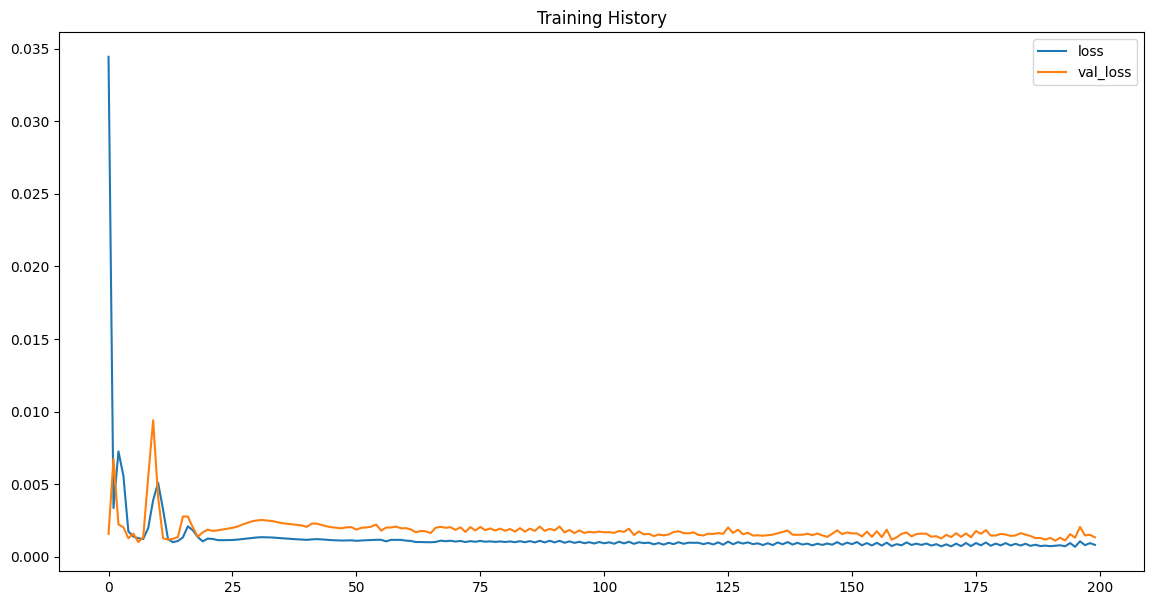

Generating predictions and analysis...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


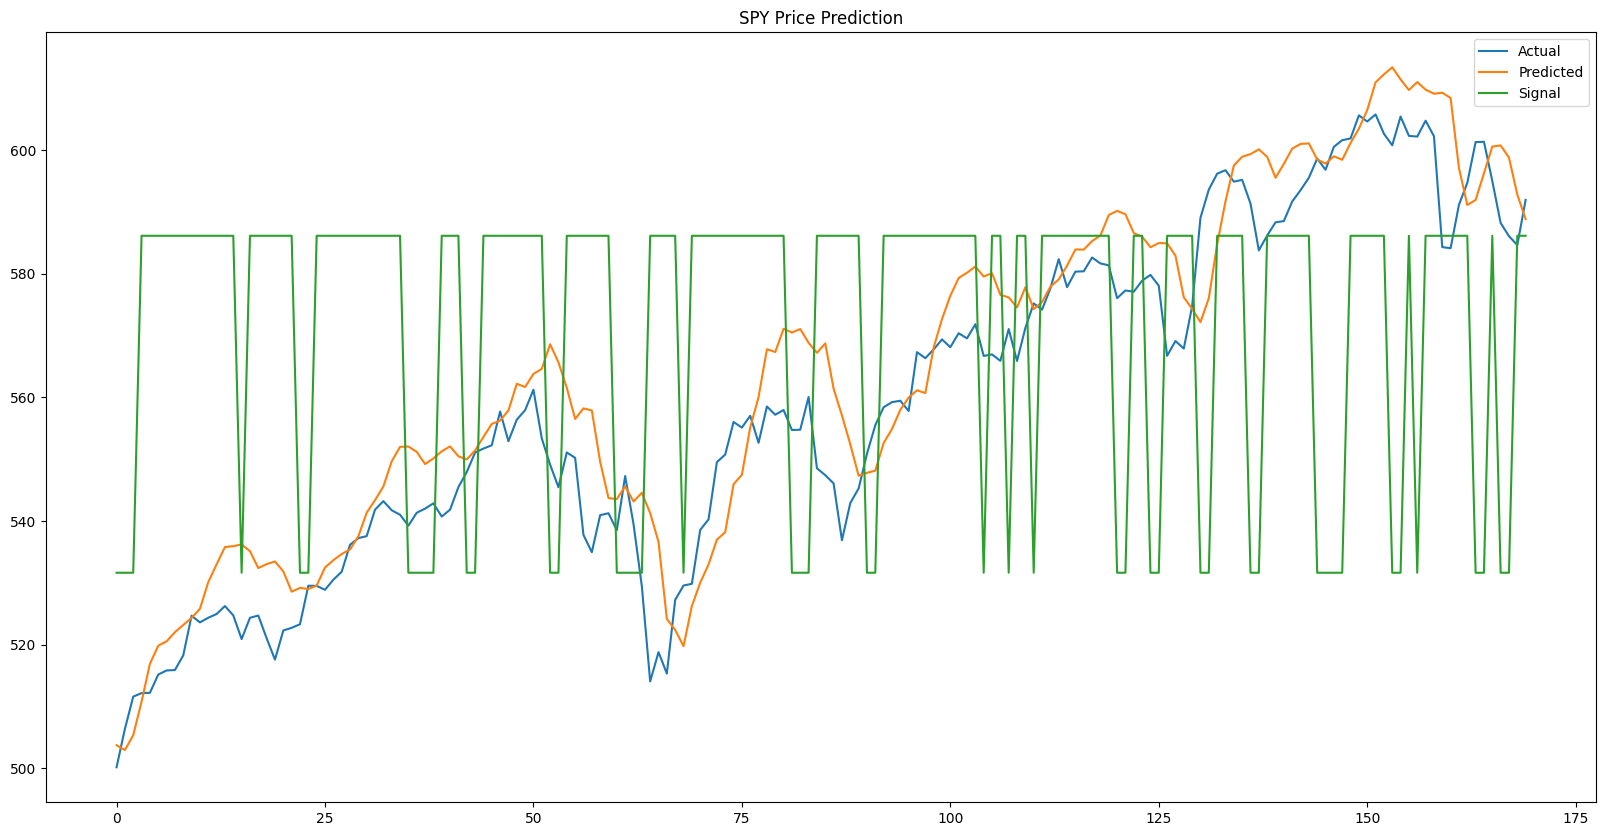


Last 5 actual values:
165    595.010010
166    588.219971
167    586.080017
168    584.640015
169    591.950012
dtype: float64

Last 5 predicted values:
165    600.568054
166    600.756775
167    598.789307
168    592.807800
169    588.835754
dtype: float32
Model saved to spy_predictor_model.keras


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import json
from datetime import datetime, timedelta

class SPYPredictor:
    def __init__(self):
        self.model = None
        self.scaler = MinMaxScaler()
    def process_data(self, data, lookback=14, gap=1):
          """Process data into sequences for the CNN"""
          # Scale the data
          scaled_data = self.scaler.fit_transform(data.values.reshape(-1, 1))

          X, Y = [], []
          for i in range(len(scaled_data) - lookback - gap):
              X.append(scaled_data[i:(i + lookback), 0])
              Y.append(scaled_data[(i + lookback + gap), 0])

          X = np.array(X)
          Y = np.array(Y)

          # Split into train/test
          train_size = int(X.shape[0] * 0.80)
          X_train, X_test = X[:train_size], X[train_size:]
          y_train, y_test = Y[:train_size], Y[train_size:]

          # Reshape for CNN
          X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
          X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

          return X_train, X_test, y_train, y_test
    def build_model(self, input_shape):
        """Build the CNN model"""
        model = Sequential([
            Conv1D(5, 1, strides=1, activation='relu', input_shape=input_shape),
            Flatten(),
            Dense(120, activation='relu'),
            Dense(1, activation='relu')
        ])

        model.compile(optimizer='adam', loss='mse')
        return model
    def train(self, X_train, y_train, X_test, y_test, epochs=200):
        """Train the model"""
        self.model = self.build_model((X_train.shape[1], 1))

        history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            validation_data=(X_test, y_test),
            shuffle=False,
            verbose=1
        )

        return history.history

    def predict_and_analyze(self, X_test, y_test):
        """Make predictions and generate analysis"""
        predictions = self.model.predict(X_test)

        # Inverse transform the scaled values
        y_actual = pd.Series(self.scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1))
        y_pred = pd.Series(self.scaler.inverse_transform(predictions).reshape(-1))

        # Calculate signals
        y_ema = y_actual.ewm(span=3).mean()
        signal = pd.Series(index=y_actual.index, data=np.zeros(y_actual.size))
        pred_diff = y_pred.diff(3)
        actual_diff = y_ema.diff(3)

        # Generate trading signals
        for i in y_actual.index:
            if (pred_diff[i] > 0 and actual_diff[i] > 0) or (pred_diff[i] < 0 and actual_diff[i] < 0):
                signal[i] = y_actual.mean() + y_actual.std()
            else:
                signal[i] = y_actual.mean() - y_actual.std()

        return y_actual, y_pred, signal


    def save_model(self, filepath='spy_predictor_model.keras'):
        """Save the trained model to a file"""
        if self.model is not None:
            self.model.save(filepath)
            print(f"Model saved to {filepath}")
        else:
            print("No model to save. Please train the model first.")

    def fetch_data(self, lookback_days=1250):
        """
        Fetch SPY data from yFinance and return a flattened pandas Series of adjusted close prices.

        Args:
            lookback_days (int): Number of days to look back for data.

        Returns:
            pd.Series: A Series containing the adjusted close prices.
        """
        try:
            # Define date range
            end_date = datetime.now()
            start_date = end_date - timedelta(days=lookback_days)

            # Fetch data using yfinance
            spy_data = yf.download('SPY', start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))

            # Check if data is retrieved successfully
            if spy_data.empty:
                print("No data retrieved for the specified date range.")
                return pd.Series()

            # Extract 'Adj Close' column
            adj_close_data = spy_data['Adj Close']

            # Debugging output (optional)
            """print("//////" * 10)
            print("Raw Adjusted Close Data:")
            print(adj_close_data)
            print("//////" * 10)"""

            # Convert to a NumPy array and then to a pandas Series
            flattened_data = np.array(adj_close_data).reshape(-1)

            # Return as a pandas Series
            return pd.Series(data=flattened_data, index=adj_close_data.index, name="SPY_Adj_Close")

        except Exception as e:
            print(f"An error occurred: {e}")
            return pd.Series()

predictor = SPYPredictor()
print("******"*50)
print(predictor.fetch_data())
print("******"*50)
def main():
    # Initialize predictor
    predictor = SPYPredictor()

    # Fetch data
    print("Fetching SPY data...")
    data = predictor.fetch_data()

    # Process data
    print("Processing data...")
    X_train, X_test, y_train, y_test = predictor.process_data(data)

    # Train model
    print("Training model...")
    history = predictor.train(X_train, y_train, X_test, y_test)

    # Plot training history
    plt.figure(figsize=(14, 7))
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Training History')
    plt.show()

    # Make predictions and analyze
    print("Generating predictions and analysis...")
    y_actual, y_pred, signal = predictor.predict_and_analyze(X_test, y_test)

    # Plot results
    plt.figure(figsize=(20, 10))
    plt.plot(y_actual, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.plot(signal, label='Signal')
    plt.title('SPY Price Prediction')
    plt.legend()
    plt.show()

    # Print last few predictions
    print("\nLast 5 actual values:")
    print(y_actual.tail())
    print("\nLast 5 predicted values:")
    print(y_pred.tail())
    predictor.save_model()

if __name__ == "__main__":
    main()

In [ ]:

file_path = "/content/spy_predictor_model.keras"

SPYModel1 = load_model(file_path)

SPYModel1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,955 (101.39 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,304 (67.60 KB)

[*********************100%***********************]  1 of 1 completed

 1/27 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


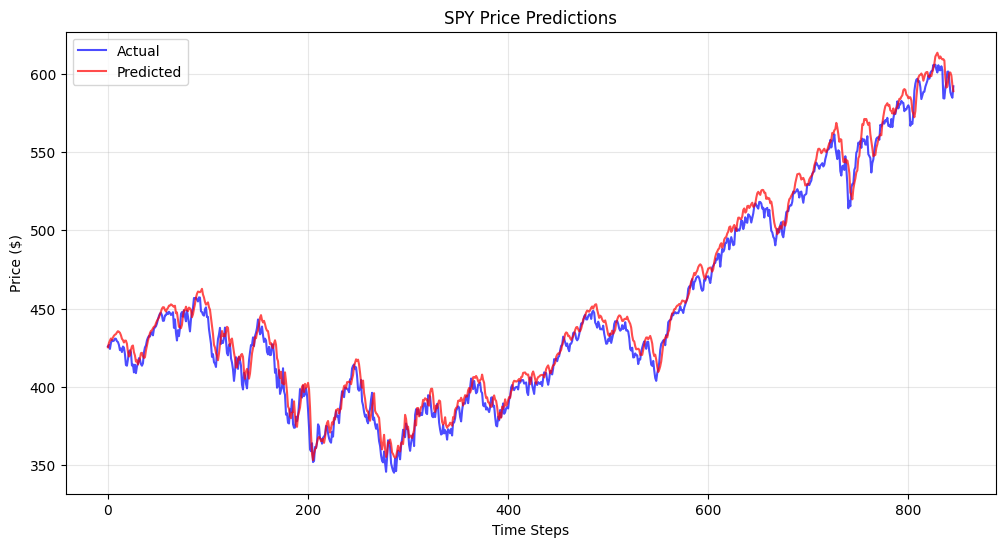


Prediction Statistics:
Mean Squared Error: 65.84
Mean Absolute Error: 6.45


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import matplotlib.pyplot as plt

def fetch_data(lookback_days=1250):
    """
    Fetch SPY data from yFinance.

    Args:
        lookback_days (int): Number of days of historical data to fetch

    Returns:
        pd.Series: Adjusted close prices
    """
    try:
        end_date = datetime.now()
        start_date = end_date - timedelta(days=lookback_days)

        spy_data = yf.download('SPY', start=start_date.strftime('%Y-%m-%d'),
                             end=end_date.strftime('%Y-%m-%d'))

        if spy_data.empty:
            print("No data retrieved for the specified date range.")
            return pd.Series()

        return spy_data['Adj Close']

    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.Series()

def process_data(data, lookback=14, gap=1):
    """
    Process price data into sequences for prediction.

    Args:
        data (pd.Series): Price time series
        lookback (int): Number of days to use for prediction
        gap (int): Number of days ahead to predict

    Returns:
        tuple: (X, y) processed sequences and targets
    """
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    X, y = [], []
    for i in range(len(scaled_data) - lookback - gap):
        X.append(scaled_data[i:(i + lookback), 0])
        y.append(scaled_data[i + lookback + gap, 0])

    X = np.array(X).reshape(-1, lookback, 1)
    y = np.array(y)

    return X, y, scaler

def predict_prices(model_path, data, lookback=14, gap=1):
    """
    Make predictions using saved model.

    Args:
        model_path (str): Path to saved Keras model
        data (pd.Series): Price time series
        lookback (int): Lookback window size
        gap (int): Prediction gap

    Returns:
        tuple: (actual_prices, predicted_prices)
    """
    # Process data
    X, y, scaler = process_data(data, lookback, gap)

    # Load model and make predictions
    model = load_model(model_path)
    predictions = model.predict(X)

    # Transform back to original scale
    actual_prices = scaler.inverse_transform(y.reshape(-1, 1))
    predicted_prices = scaler.inverse_transform(predictions)

    return actual_prices, predicted_prices

def plot_predictions(actual, predicted, title='SPY Price Predictions'):
    """Plot actual vs predicted prices"""
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual', color='blue', alpha=0.7)
    plt.plot(predicted, label='Predicted', color='red', alpha=0.7)
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Example usage
if __name__ == "__main__":
    # Fetch data once
    data = fetch_data()

    # Make predictions
    actual, predicted = predict_prices('/content/spy_predictor_model.keras', data)

    # Plot results
    plot_predictions(actual, predicted)

    # Print some statistics
    mse = np.mean((actual - predicted) ** 2)
    mae = np.mean(np.abs(actual - predicted))
    print(f"\nPrediction Statistics:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")


Starting layer analysis...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,955 (101.39 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,304 (67.60 KB)


Analyzing Original Model:
Layer Information:

Layer 0: conv1d (Conv1D)
Number of weight arrays: 2
Weight array 0 shape: (1, 1, 5)
Weight array 1 shape: (5,)

Layer 1: flatten (Flatten)

Layer 2: dense (Dense)
Number of weight arrays: 2
Weight array 0 shape: (70, 120)
Weight array 1 shape: (120,)

Layer 3: dense_1 (Dense)
Number of weight arrays: 2
Weight array 0 shape: (120, 1)
Weight array 1 shape: (1,)

Analyzing Layer 0: conv1d

Weight Statistics:
mean: 0.1497
std: 0.6434
min: -0.9908
max: 0.8531
sparsity: 0.0000
total_weights: 5
nonzero_weights: 5
bias_mean: -0.0448
bias_std: 0.0319
bias_nonzero: 4
Skipping layer 0: conv1d (Conv1D)


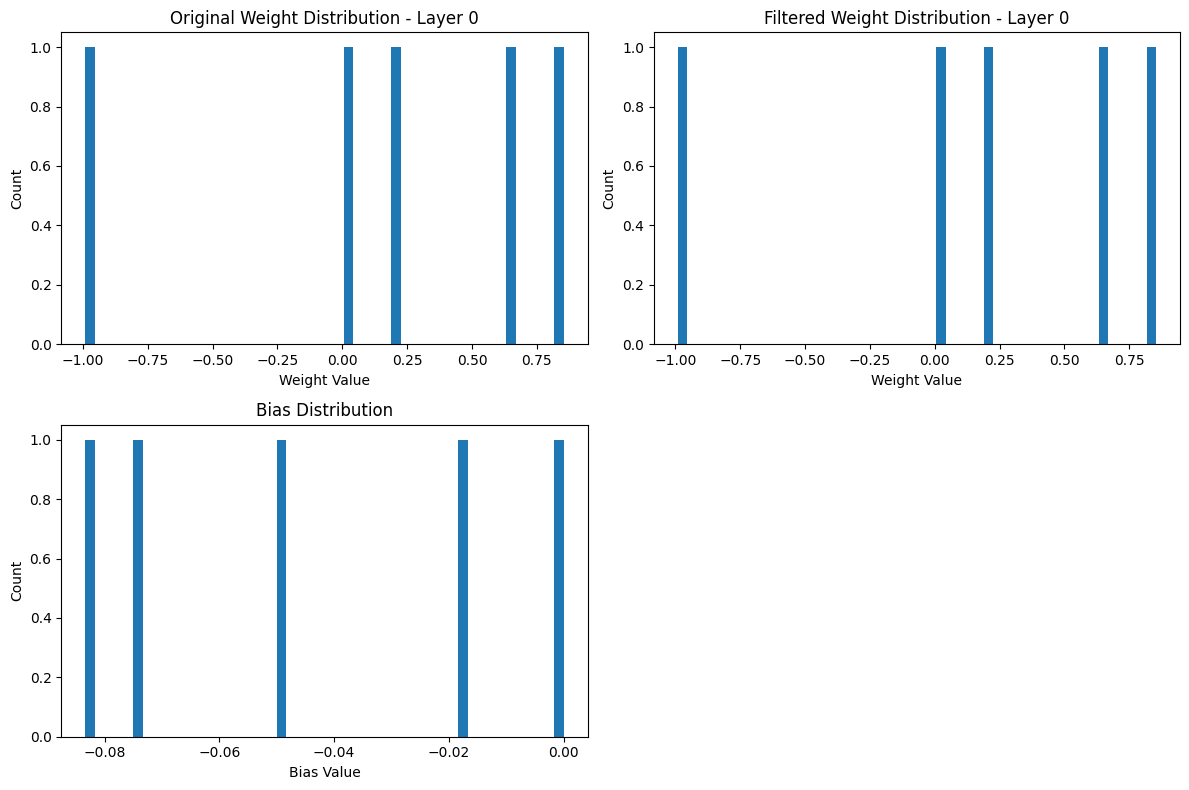


Analyzing Layer 2: dense

Weight Statistics:
mean: -0.0055
std: 0.1126
min: -0.7948
max: 0.3580
sparsity: 0.0000
total_weights: 8,400
nonzero_weights: 8,400
bias_mean: -0.0040
bias_std: 0.0247
bias_nonzero: 120


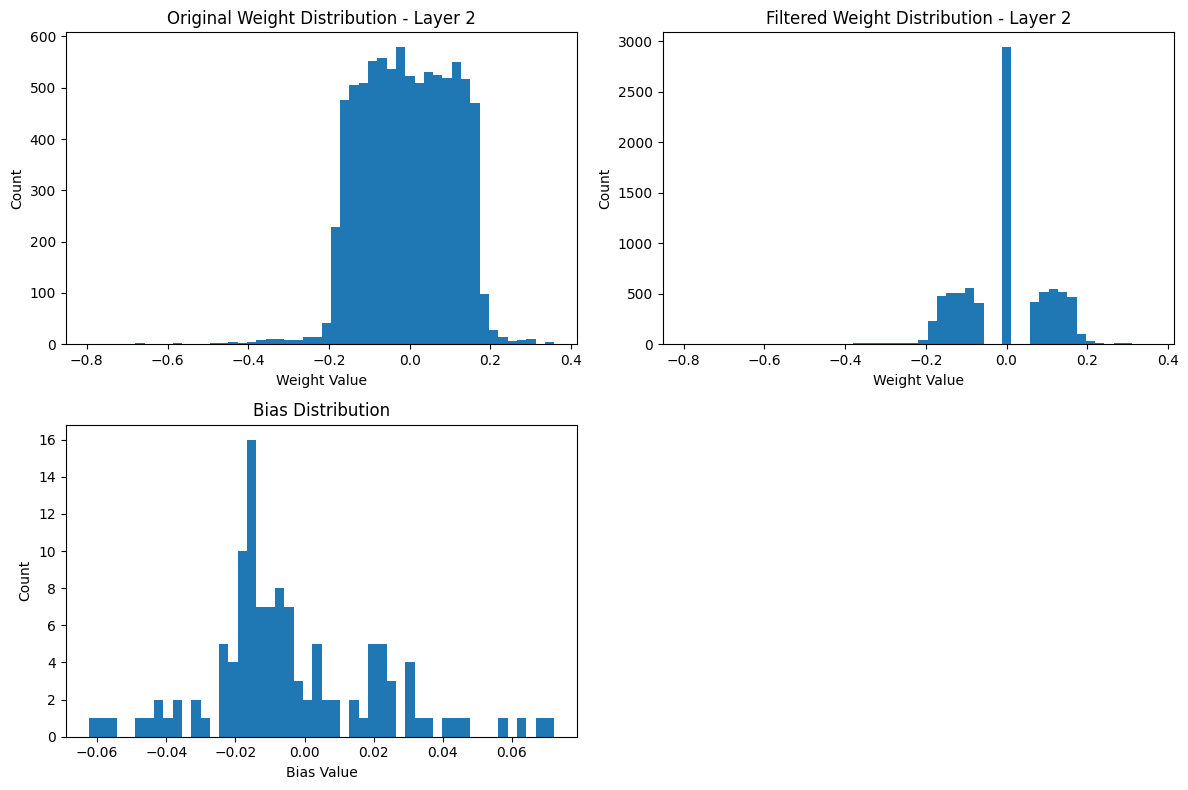


Analyzing Layer 3: dense_1

Weight Statistics:
mean: -0.0050
std: 0.1858
min: -0.6050
max: 0.7708
sparsity: 0.0000
total_weights: 120
nonzero_weights: 120
bias_mean: 0.0412
bias_std: 0.0000
bias_nonzero: 1


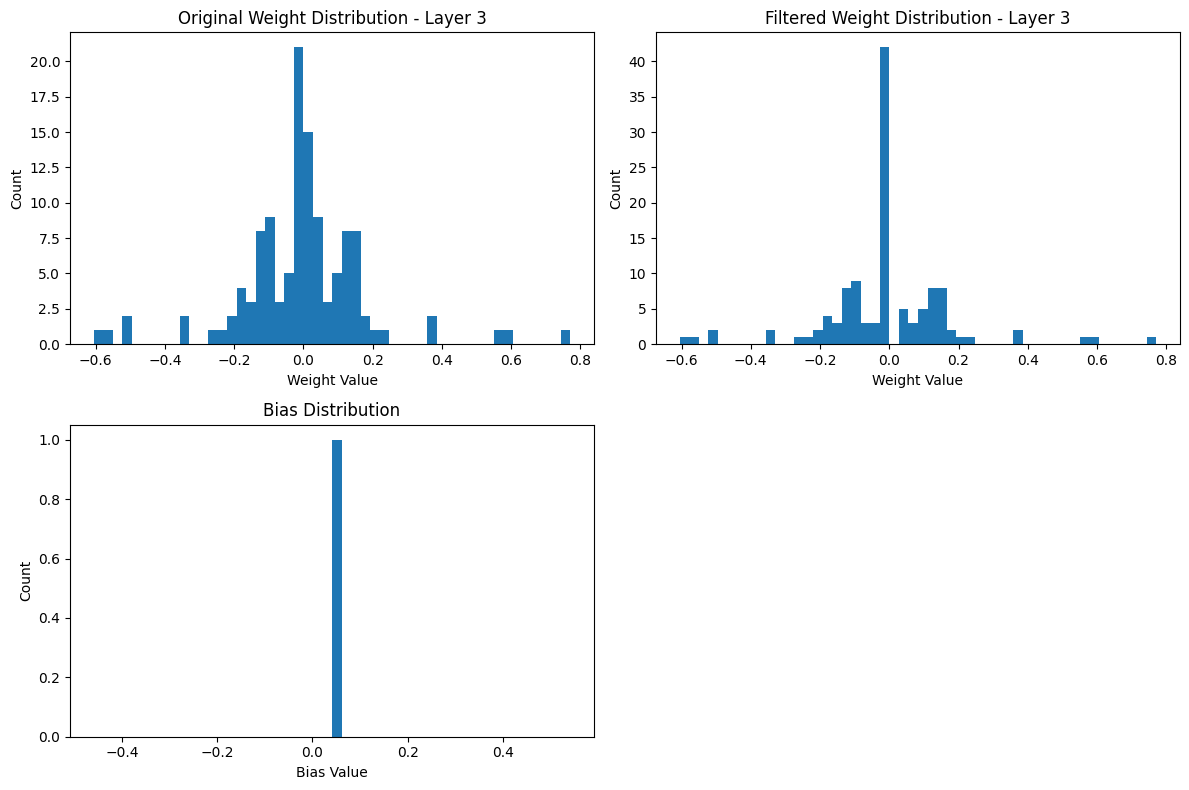


Filtered Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,651 (33.79 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)


Analyzing Filtered Model:
Layer Information:

Layer 0: conv1d (Conv1D)
Number of weight arrays: 2
Weight array 0 shape: (1, 1, 5)
Weight array 1 shape: (5,)

Layer 1: flatten (Flatten)

Layer 2: dense (Dense)
Number of weight arrays: 2
Weight array 0 shape: (70, 120)
Weight array 1 shape: (120,)

Layer 3: dense_1 (Dense)
Number of weight arrays: 2
Weight array 0 shape: (120, 1)
Weight array 1 shape: (1,)

Analyzing Layer 0: conv1d

Weight Statistics:
mean: 0.1497
std: 0.6434
min: -0.9908
max: 0.8531
sparsity: 0.0000
total_weights: 5
nonzero_weights: 5
bias_mean: -0.0448
bias_std: 0.0319
bias_nonzero: 4
Skipping layer 0: conv1d (Conv1D)


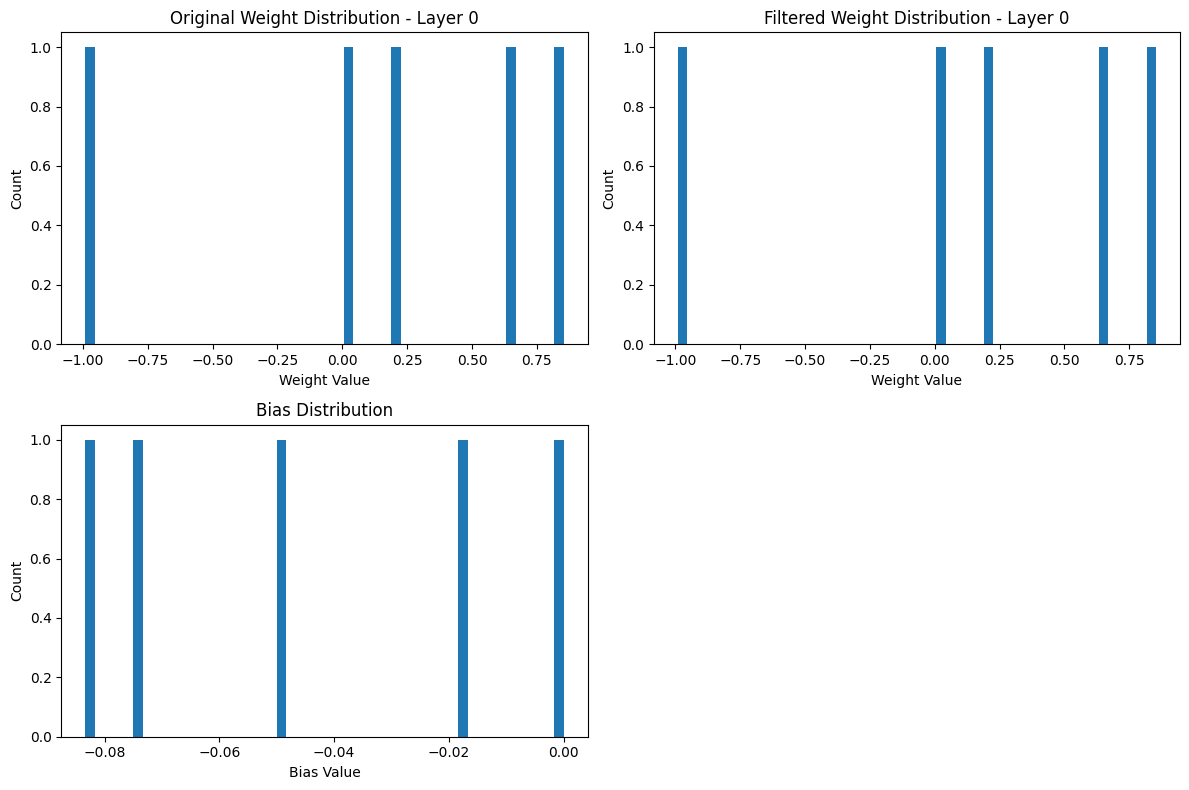


Analyzing Layer 2: dense

Weight Statistics:
mean: -0.0052
std: 0.1105
min: -0.7948
max: 0.3580
sparsity: 0.3500
total_weights: 8,400
nonzero_weights: 5,460
bias_mean: -0.0040
bias_std: 0.0247
bias_nonzero: 120


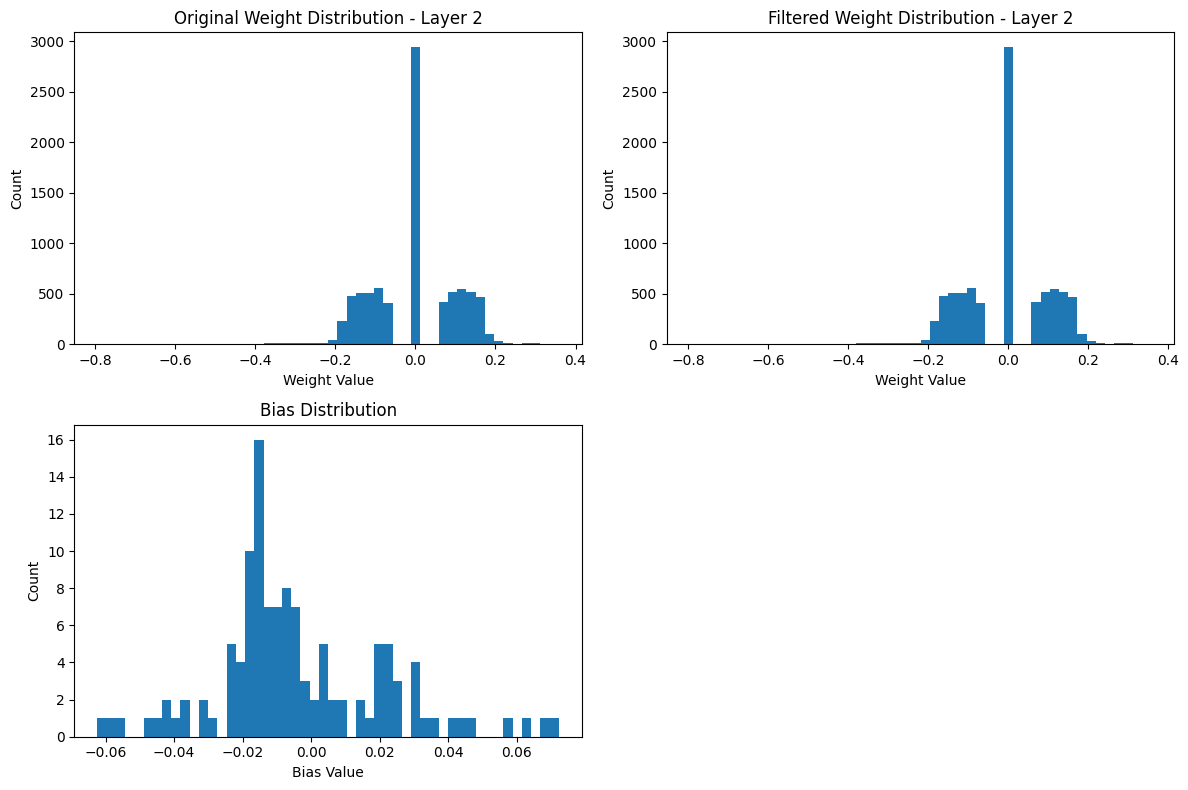


Analyzing Layer 3: dense_1

Weight Statistics:
mean: -0.0043
std: 0.1855
min: -0.6050
max: 0.7708
sparsity: 0.3500
total_weights: 120
nonzero_weights: 78
bias_mean: 0.0412
bias_std: 0.0000
bias_nonzero: 1


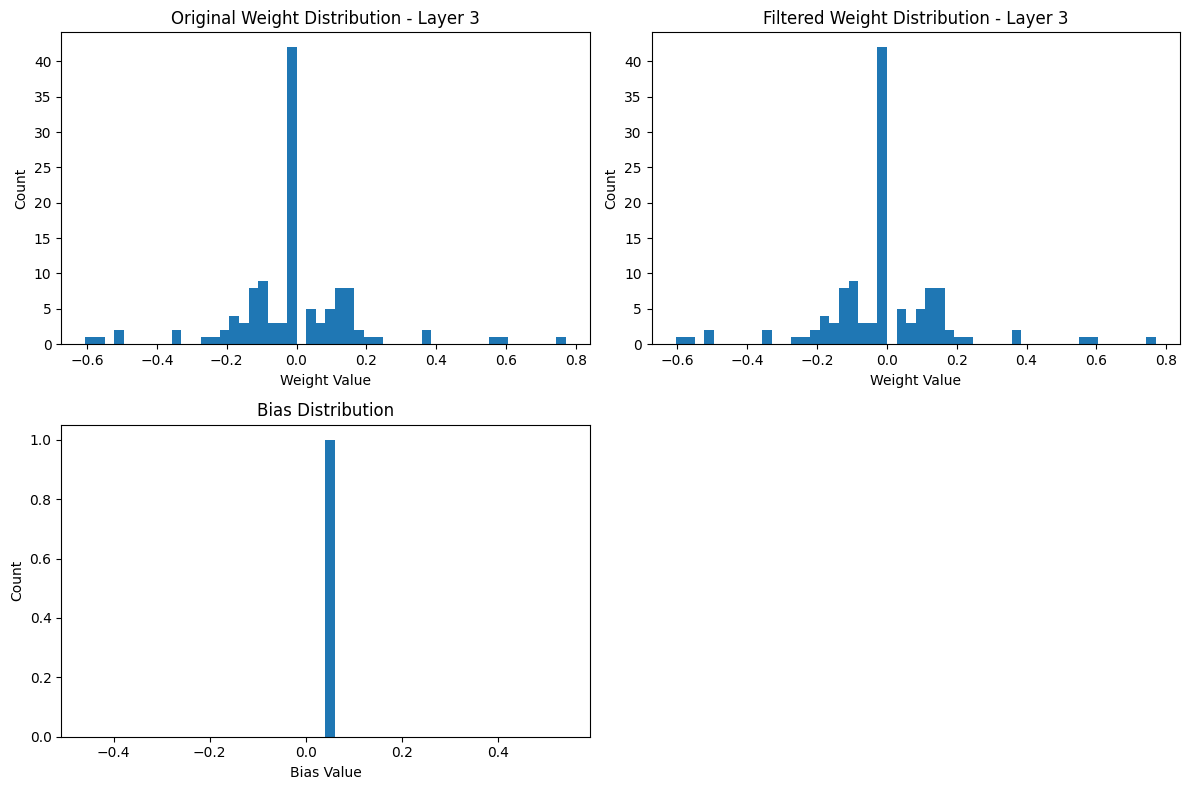

[*********************100%***********************]  1 of 1 completed

 1/27 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


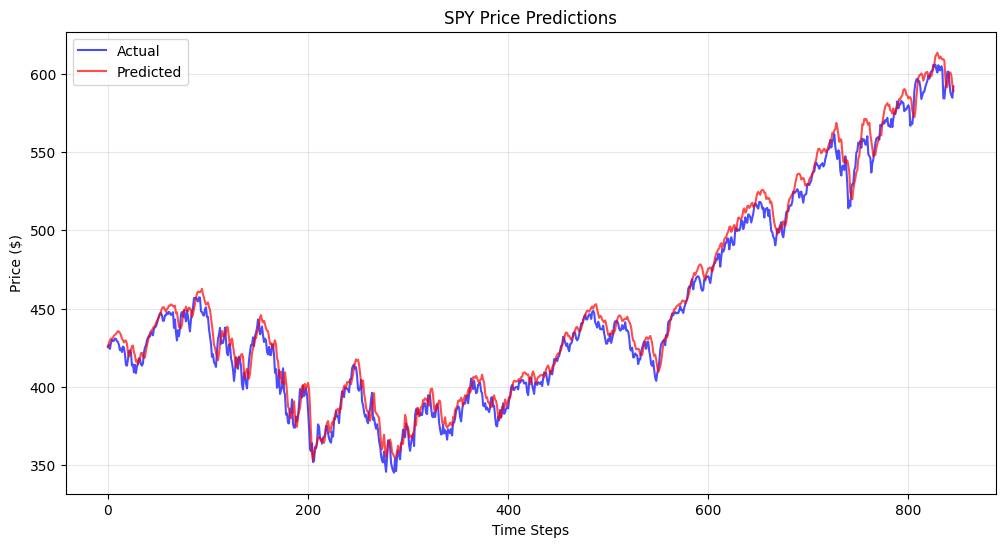


Prediction Statistics:
Mean Squared Error: 65.84
Mean Absolute Error: 6.45


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,955 (101.39 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,304 (67.60 KB)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


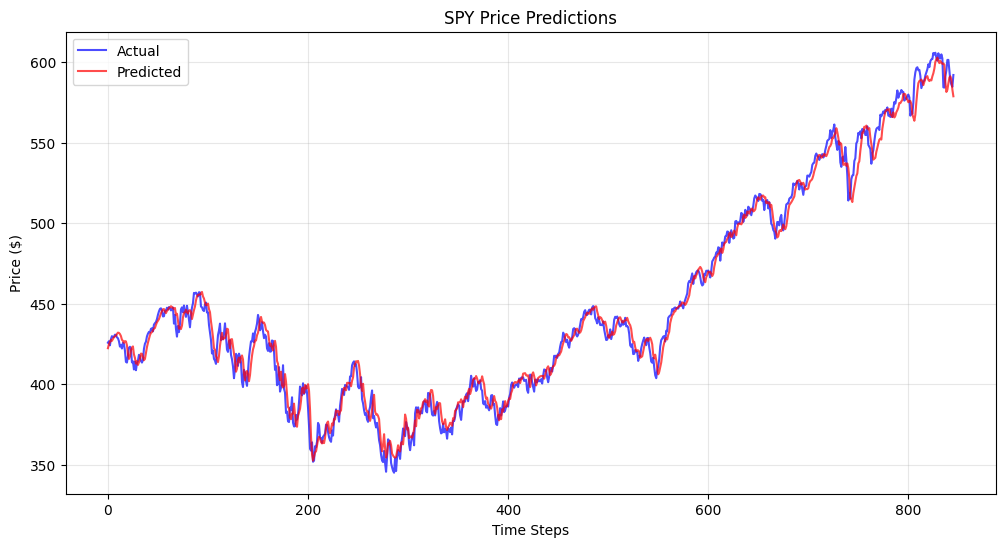


Prediction Statistics:
Mean Squared Error: 47.62
Mean Absolute Error: 5.34


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,955 (101.39 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,304 (67.60 KB)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import tensorflow as tf

class SimpleLayerAnalyzer:
    def __init__(self, model):
        """Initialize analyzer with a trained model"""
        self.model = model
        self.filtered_weights = {}
        self.non_prunable_layers = {
            "Conv2D", "Flatten", "BatchNormalization", "LayerNormalization",
            "MaxPooling2D", "AveragePooling2D", "Dropout", "Conv1D"
        }

    def print_layer_info(self):
        """Print basic information about each layer"""
        for i, layer in enumerate(self.model.layers):
            print(f"\nLayer {i}: {layer.name} ({layer.__class__.__name__})")
            weights = layer.get_weights()
            if weights:
                print(f"Number of weight arrays: {len(weights)}")
                for j, w in enumerate(weights):
                    print(f"Weight array {j} shape: {w.shape}")

    def analyze_weights(self, layer_index: int) -> Dict[str, np.ndarray]:
        """Analyze weights of a specific layer"""
        layer = self.model.layers[layer_index]
        weights = layer.get_weights()

        if not weights:
            return {}

        analysis = {}

        # Analyze the main weights (usually the first array)
        if len(weights) > 0:
            main_weights = weights[0]
            analysis['mean'] = np.mean(main_weights)
            analysis['std'] = np.std(main_weights)
            analysis['min'] = np.min(main_weights)
            analysis['max'] = np.max(main_weights)
            analysis['sparsity'] = np.mean(main_weights == 0)
            analysis['total_weights'] = main_weights.size
            analysis['nonzero_weights'] = np.count_nonzero(main_weights)

        # Analyze bias if present (usually the second array)
        if len(weights) > 1:
            bias = weights[1]
            analysis['bias_mean'] = np.mean(bias)
            analysis['bias_std'] = np.std(bias)
            analysis['bias_nonzero'] = np.count_nonzero(bias)

        return analysis

    def filter_weights(self, layer_index: int, stats: Dict[str, float]) -> List[np.ndarray]:
        """Filter weights while preserving original tensor shapes."""
        layer = self.model.layers[layer_index]
        layer_type = layer.__class__.__name__
        weights = layer.get_weights()

        # Skip layers that should not be altered
        if not weights or layer_type in self.non_prunable_layers:
            print(f"Skipping layer {layer_index}: {layer.name} ({layer_type})")
            return weights  # Return original weights for non-prunable layers

        filtered = []
        main_weights = weights[0]

        # Calculate percentiles on the absolute values of weights
        abs_weights = np.abs(main_weights)
        threshold = np.percentile(abs_weights, 35)  # Keep top 50% of weights by magnitude

        # Create mask and apply it while preserving original shape
        mask = abs_weights > threshold
        filtered_weights = main_weights * mask  # Zero out small weights
        filtered.append(filtered_weights)  # Keep original shape

        # Keep bias if present, unchanged
        if len(weights) > 1:
            filtered.append(weights[1])

        return filtered

    def plot_weight_distribution(self, layer_index: int):
        """Plot the distribution of weights in a layer"""
        layer = self.model.layers[layer_index]
        weights = layer.get_weights()
        filtered = self.filtered_weights.get(layer_index, None)

        if not weights:
            print(f"Layer {layer_index} ({layer.name}) has no weights to plot")
            return

        plt.figure(figsize=(12, 8))

        # Plot original weights
        plt.subplot(2, 2, 1)
        plt.hist(weights[0].flatten(), bins=50)
        plt.title(f'Original Weight Distribution - Layer {layer_index}')
        plt.xlabel('Weight Value')
        plt.ylabel('Count')

        # Plot filtered weights if available
        if filtered is not None:
            plt.subplot(2, 2, 2)
            plt.hist(filtered[0].flatten(), bins=50)
            plt.title(f'Filtered Weight Distribution - Layer {layer_index}')
            plt.xlabel('Weight Value')
            plt.ylabel('Count')

        # Plot bias if present
        if len(weights) > 1:
            plt.subplot(2, 2, 3)
            plt.hist(weights[1].flatten(), bins=50)
            plt.title('Bias Distribution')
            plt.xlabel('Bias Value')
            plt.ylabel('Count')

        plt.tight_layout()
        plt.show()

def create_filtered_model(original_model, filtered_weights):
    """Create a new model with the same architecture and assign filtered weights"""
    new_model = tf.keras.models.clone_model(original_model)

    if original_model.optimizer:
        new_model.compile(
            optimizer=original_model.optimizer.__class__(),
            loss=original_model.loss,
            metrics=original_model.metrics
        )

    # Set weights for all layers
    for i, layer in enumerate(original_model.layers):
        if i in filtered_weights:
            new_model.layers[i].set_weights(filtered_weights[i])
        else:
            # Copy original weights for layers that weren't filtered
            new_model.layers[i].set_weights(layer.get_weights())

    return new_model

def analyze_model(model):
    """Helper function to run all analyses and create filtered model"""
    analyzer = SimpleLayerAnalyzer(model)
    filtered_weights = {}

    print("Layer Information:")
    analyzer.print_layer_info()

    for i, layer in enumerate(model.layers):
        if layer.get_weights():
            print(f"\nAnalyzing Layer {i}: {layer.name}")

            stats = analyzer.analyze_weights(i)
            print("\nWeight Statistics:")
            for key, value in stats.items():
                if isinstance(value, (int, np.integer)):
                    print(f"{key}: {value:,}")
                else:
                    print(f"{key}: {value:.4f}")

            filtered = analyzer.filter_weights(i, stats)
            if filtered:
                filtered_weights[i] = filtered
                analyzer.filtered_weights[i] = filtered

            analyzer.plot_weight_distribution(i)

    return filtered_weights
def fetch_data(lookback_days=1250):
    """
    Fetch SPY data from yFinance.

    Args:
        lookback_days (int): Number of days of historical data to fetch

    Returns:
        pd.Series: Adjusted close prices
    """
    try:
        end_date = datetime.now()
        start_date = end_date - timedelta(days=lookback_days)

        spy_data = yf.download('SPY', start=start_date.strftime('%Y-%m-%d'),
                             end=end_date.strftime('%Y-%m-%d'))

        if spy_data.empty:
            print("No data retrieved for the specified date range.")
            return pd.Series()

        return spy_data['Adj Close']

    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.Series()

def process_data(data, lookback=14, gap=1):
    """
    Process price data into sequences for prediction.

    Args:
        data (pd.Series): Price time series
        lookback (int): Number of days to use for prediction
        gap (int): Number of days ahead to predict

    Returns:
        tuple: (X, y) processed sequences and targets
    """
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    X, y = [], []
    for i in range(len(scaled_data) - lookback - gap):
        X.append(scaled_data[i:(i + lookback), 0])
        y.append(scaled_data[i + lookback + gap, 0])

    X = np.array(X).reshape(-1, lookback, 1)
    y = np.array(y)

    return X, y, scaler

def predict_prices(model_path, data, lookback=14, gap=1):
    """
    Make predictions using saved model.

    Args:
        model_path (str): Path to saved Keras model
        data (pd.Series): Price time series
        lookback (int): Lookback window size
        gap (int): Prediction gap

    Returns:
        tuple: (actual_prices, predicted_prices)
    """
    # Process data
    X, y, scaler = process_data(data, lookback, gap)

    # Load model and make predictions
    model = load_model(model_path)
    predictions = model.predict(X)

    # Transform back to original scale
    actual_prices = scaler.inverse_transform(y.reshape(-1, 1))
    predicted_prices = scaler.inverse_transform(predictions)

    return actual_prices, predicted_prices

def plot_predictions(actual, predicted, title='SPY Price Predictions'):
    """Plot actual vs predicted prices"""
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual', color='blue', alpha=0.7)
    plt.plot(predicted, label='Predicted', color='red', alpha=0.7)
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Main execution
if __name__ == "__main__":
    print("\nStarting layer analysis...")
    SPYModel1.summary()

    print("\nAnalyzing Original Model:")
    filtered_weights = analyze_model(SPYModel1)

    filtered_model = create_filtered_model(SPYModel1, filtered_weights)
    print("\nFiltered Model Summary:")
    filtered_model.summary()
    filtered_model.save("pruned.keras")
    print("\nAnalyzing Filtered Model:")
    analyze_model(filtered_model)

    # Fetch data once
    data = fetch_data()

    # Make predictions
    actual, predicted = predict_prices('/content/spy_predictor_model.keras', data)

    # Plot results
    plot_predictions(actual, predicted)

    # Print some statistics
    mse = np.mean((actual - predicted) ** 2)
    mae = np.mean(np.abs(actual - predicted))
    print(f"\nPrediction Statistics:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")


    file_path = "/content/spy_predictor_model.keras"

    SPYModel1 = load_model(file_path)

    SPYModel1.summary()

    print("||||||||" * 100)

        # Make predictions
    actual, predicted = predict_prices('/content/pruned.keras', data)

    # Plot results
    plot_predictions(actual, predicted)

    # Print some statistics
    mse = np.mean((actual - predicted) ** 2)
    mae = np.mean(np.abs(actual - predicted))
    print(f"\nPrediction Statistics:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")


    file_path = "/content/pruned.keras"

    pruned = load_model(file_path)

    pruned.summary()

In [ ]:

# Load the original model
file_path = "/content/spy_predictor_model.keras"
SPYModel1 = load_model(file_path)

# Print summary of SPYModel1
print("Summary of SPYModel1:")
SPYModel1.summary()

# Print weights of the 2nd layer in SPYModel1
print("\nWeights of layer 2 in SPYModel1:")
print(SPYModel1.layers[2].get_weights())

# Load the pruned model
file_path = "/content/pruned.keras"
pruned = load_model(file_path)

# Print summary of pruned model
print("\nSummary of pruned model:")
pruned.summary()

# Print weights of the 2nd layer in pruned model
print("\nWeights of layer 2 in pruned model:")
print(pruned.layers[2].get_weights())


Summary of SPYModel1:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,955 (101.39 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,304 (67.60 KB)


Weights of layer 2 in SPYModel1:
[array([[-0.01345877,  0.07964328,  0.05220969, ..., -0.08056132,
         0.09447619, -0.10019791],
       [ 0.16854891, -0.0607518 , -0.02993528, ...,  0.08301602,
        -0.19677335,  0.12831263],
       [ 0.00798018, -0.07057504, -0.13162121, ..., -0.08692451,
        -0.0104689 ,  0.07576858],
       ...,
       [-0.10672539, -0.04190616, -0.0205291 , ..., -0.07606712,
         0.10795957, -0.16473131],
       [ 0.04860237, -0.2832246 ,  0.01642443, ..., -0.1897352 ,
        -0.10694564,  0.0377845 ],
       [ 0.05601234,  0.13261333,  0.09206077, ..., -0.10504635,
         0.19913353, -0.07694121]], dtype=float32), array([-0.00655757,  0.07218812, -0.01107342, -0.01591142,  0.00255729,
       -0.00130346, -0.00825663, -0.02237794, -0.01712118,  0.02353473,
       -0.00786686, -0.01475185, -0.00573822, -0.01639718, -0.01058601,
       -0.03620933, -0.01847692, -0.03020095, -0.01414073, -0.01455388,
       -0.01347476, -0.05783569, -0.01600554,  0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,955 (101.39 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,304 (67.60 KB)


Weights of layer 2 in pruned model:
[array([[-0.        ,  0.07964328,  0.        , ..., -0.08056132,
         0.09447619, -0.10019791],
       [ 0.16854891, -0.        , -0.        , ...,  0.08301602,
        -0.19677335,  0.12831263],
       [ 0.        , -0.07057504, -0.13162121, ..., -0.08692451,
        -0.        ,  0.07576858],
       ...,
       [-0.10672539, -0.        , -0.        , ..., -0.07606712,
         0.10795957, -0.16473131],
       [ 0.        , -0.2832246 ,  0.        , ..., -0.1897352 ,
        -0.10694564,  0.        ],
       [ 0.        ,  0.13261333,  0.09206077, ..., -0.10504635,
         0.19913353, -0.07694121]], dtype=float32), array([-0.00655757,  0.07218812, -0.01107342, -0.01591142,  0.00255729,
       -0.00130346, -0.00825663, -0.02237794, -0.01712118,  0.02353473,
       -0.00786686, -0.01475185, -0.00573822, -0.01639718, -0.01058601,
       -0.03620933, -0.01847692, -0.03020095, -0.01414073, -0.01455388,
       -0.01347476, -0.05783569, -0.01600554,

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Layer
from typing import List, Tuple, Dict, Union

def get_layer_output_shape(layer: Layer, prev_shape: tuple) -> tuple:
    """Calculate output shape of a layer given previous layer's output shape."""
    if isinstance(layer, Conv1D):
        return (prev_shape[0], layer.filters)
    elif isinstance(layer, Flatten):
        return (np.prod(prev_shape),)
    elif isinstance(layer, Dense):
        return (layer.units,)
    else:
        return prev_shape

def create_compact_model(original_path: str, pruned_path: str) -> Tuple[tf.keras.Model, List[Dict]]:
    """
    Create compact model preserving Conv1D and Flatten layers while pruning Dense layers.

    Args:
        original_path: Path to original model
        pruned_path: Path to pruned model
    Returns:
        Tuple of (compact_model, layer_info)
    """
    # Load models
    original_model = load_model(original_path)
    pruned_model = load_model(pruned_path)

    # Initialize model
    model = Sequential()
    layer_info = []
    current_shape = original_model.input_shape[1:]

    # First, create the model structure without setting weights
    for layer in pruned_model.layers:
        if isinstance(layer, Conv1D):
            model.add(Conv1D(
                filters=layer.filters,
                kernel_size=layer.kernel_size,
                padding=layer.padding,
                activation=layer.activation,
                input_shape=current_shape if len(model.layers) == 0 else None
            ))
            current_shape = get_layer_output_shape(layer, current_shape)
            layer_info.append({
                'type': 'Conv1D',
                'weights': layer.get_weights()
            })

        elif isinstance(layer, Flatten):
            model.add(Flatten())
            current_shape = get_layer_output_shape(layer, current_shape)
            layer_info.append({
                'type': 'Flatten',
                'weights': []
            })

        elif isinstance(layer, Dense):
            weights, biases = layer.get_weights()
            # Find active neurons
            active_outputs = np.where(np.any(weights != 0, axis=0))[0]
            if len(active_outputs) == 0:
                active_outputs = np.array([0])  # Keep at least one neuron

            # Create pruned weights and biases
            pruned_weights = weights[:, active_outputs]
            pruned_biases = biases[active_outputs]

            # Add Dense layer
            model.add(Dense(
                units=len(active_outputs),
                activation=layer.activation,
                input_shape=(np.prod(current_shape),) if len(model.layers) == 0 else None
            ))
            current_shape = (len(active_outputs),)
            layer_info.append({
                'type': 'Dense',
                'weights': [pruned_weights, pruned_biases],
                'active_outputs': active_outputs
            })

    # Build the model with a sample input to initialize weights
    sample_input = np.zeros((1,) + original_model.input_shape[1:])
    model.predict(sample_input)

    # Now set the weights for all layers
    for layer_idx, info in enumerate(layer_info):
        if info['weights']:  # Only set weights if they exist
            model.layers[layer_idx].set_weights(info['weights'])

    return model, layer_info

def verify_model(original_model: tf.keras.Model, compact_model: tf.keras.Model, layer_info: List[Dict]) -> None:
    """
    Verify the compact model produces similar outputs to the original model.
    """
    # Generate sample input
    input_shape = original_model.input_shape[1:]
    sample_input = np.random.random((1,) + input_shape)

    # Get outputs
    original_output = original_model.predict(sample_input)
    compact_output = compact_model.predict(sample_input)

    # Get the final layer info
    final_layer = layer_info[-1]
    if final_layer['type'] == 'Dense':
        active_outputs = final_layer['active_outputs']
        comparable_original_output = original_output[:, active_outputs]
    else:
        comparable_original_output = original_output

    print("\nModel Verification:")
    print(f"Original model input shape: {sample_input.shape}")
    print(f"Original model output shape: {original_output.shape}")
    print(f"Compact model input shape: {sample_input.shape}")
    print(f"Compact model output shape: {compact_output.shape}")

    if comparable_original_output.shape == compact_output.shape:
        max_diff = np.max(np.abs(comparable_original_output - compact_output))
        print(f"\nMaximum difference between outputs: {max_diff:.6f}")
    else:
        print("\nWarning: Output shapes differ, cannot compare directly")

# Example usage
if __name__ == "__main__":
    original_path = "/content/spy_predictor_model.keras"
    pruned_path = "/content/pruned.keras"

    # Create compact model
    compact_model, layer_info = create_compact_model(original_path, pruned_path)

    # Print model summary
    print("\nCompact model summary:")
    compact_model.summary()

    # Print layer information
    print("\nLayer details:")
    for i, info in enumerate(layer_info):
        print(f"\nLayer {i} ({info['type']}):")
        if info['type'] == 'Dense':
            print(f"Active neurons: {len(info['active_outputs'])}")
            print(f"Weight shape: {info['weights'][0].shape}")
        elif info['type'] == 'Conv1D':
            print(f"Filters: {info['weights'][0].shape[-1]}")
            print(f"Kernel size: {info['weights'][0].shape[0]}")

    # Save the compact model
    compact_model.save("compact_model.keras")

    # Verify the model
    original_model = load_model(original_path)
    verify_model(original_model, compact_model, layer_info)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

Compact model summary:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,651 (33.79 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)


Layer details:

Layer 0 (Conv1D):
Filters: 5
Kernel size: 1

Layer 1 (Flatten):

Layer 2 (Dense):
Active neurons: 120
Weight shape: (70, 120)

Layer 3 (Dense):
Active neurons: 1
Weight shape: (120, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Model Verification:
Original model input shape: (1, 14, 1)
Original model output shape: (1, 1)
Compact model input shape: (1, 14, 1)
Compact model output shape: (1, 1)

Maximum difference between outputs: 0.047518


In [ ]:
compact_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,651 (33.79 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

[*********************100%***********************]  1 of 1 completed


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


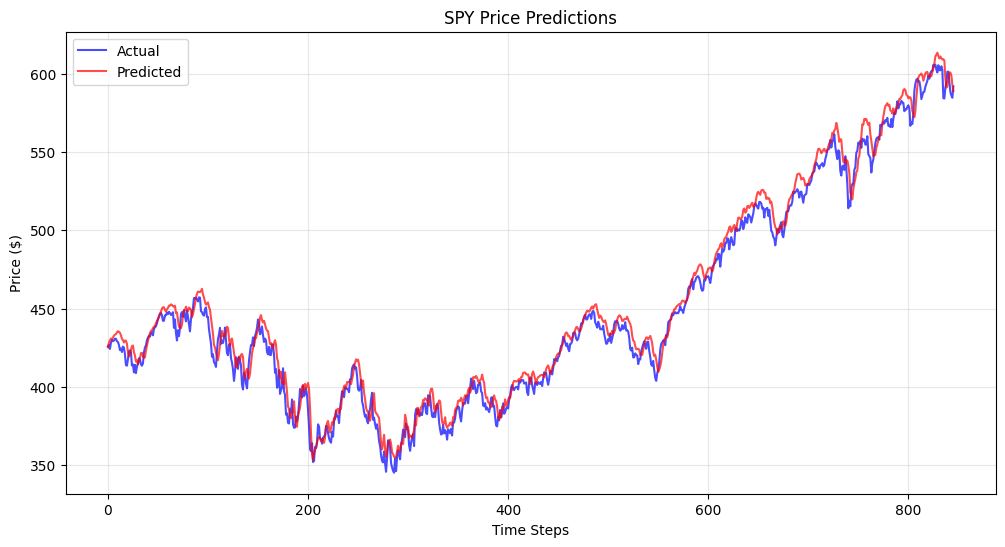


Prediction Statistics:
Mean Squared Error: 65.84
Mean Absolute Error: 6.45


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,955 (101.39 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,304 (67.60 KB)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


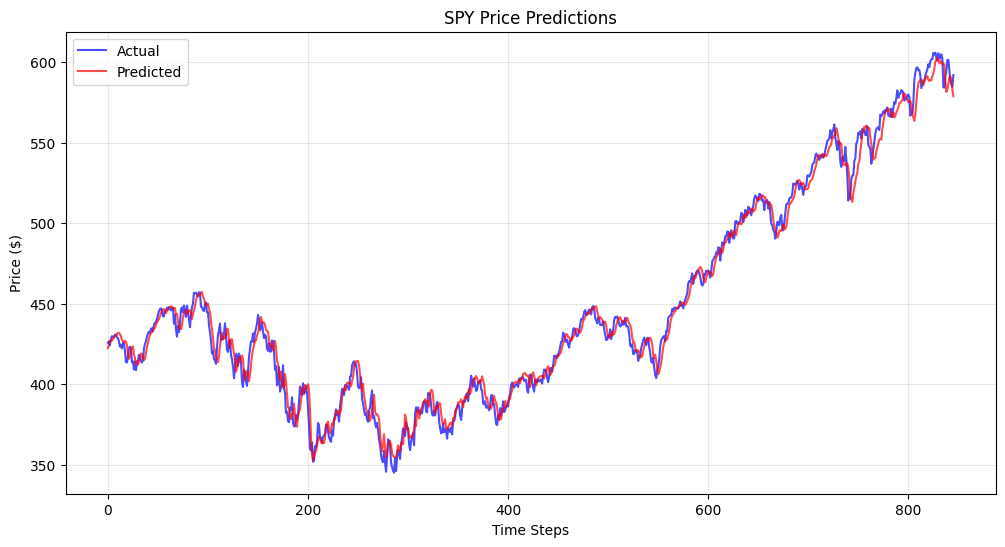


Prediction Statistics:
Mean Squared Error: 47.62
Mean Absolute Error: 5.34


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 14, 5)               │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 120)                 │           8,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,651 (33.79 KB)

 Trainable params: 8,651 (33.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:


# Example usage
if __name__ == "__main__":
    # Fetch data once
    data = fetch_data()

    # Make predictions
    actual, predicted = predict_prices('/content/spy_predictor_model.keras', data)

    # Plot results
    plot_predictions(actual, predicted)

    # Print some statistics
    mse = np.mean((actual - predicted) ** 2)
    mae = np.mean(np.abs(actual - predicted))
    print(f"\nPrediction Statistics:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")


    file_path = "/content/spy_predictor_model.keras"

    SPYModel1 = load_model(file_path)

    SPYModel1.summary()

    print("||||||||" * 100)

        # Make predictions
    actual, predicted = predict_prices('/content/compact_model.keras', data)

    # Plot results
    plot_predictions(actual, predicted)

    # Print some statistics
    mse = np.mean((actual - predicted) ** 2)
    mae = np.mean(np.abs(actual - predicted))
    print(f"\nPrediction Statistics:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")


    file_path = "/content/compact_model.keras"

    pruned = load_model(file_path)

    pruned.summary()

[*********************100%***********************]  1 of 1 completed


Model Comparison Report: SPYModel vs CompactModel

1. Architecture Comparison:

2. Parameter Comparison:
              Total Parameters  Trainable Parameters  Non-trainable Parameters
SPYModel                8651.0                8651.0                       0.0
CompactModel            8651.0                8651.0                       0.0

3. Weight Distribution:


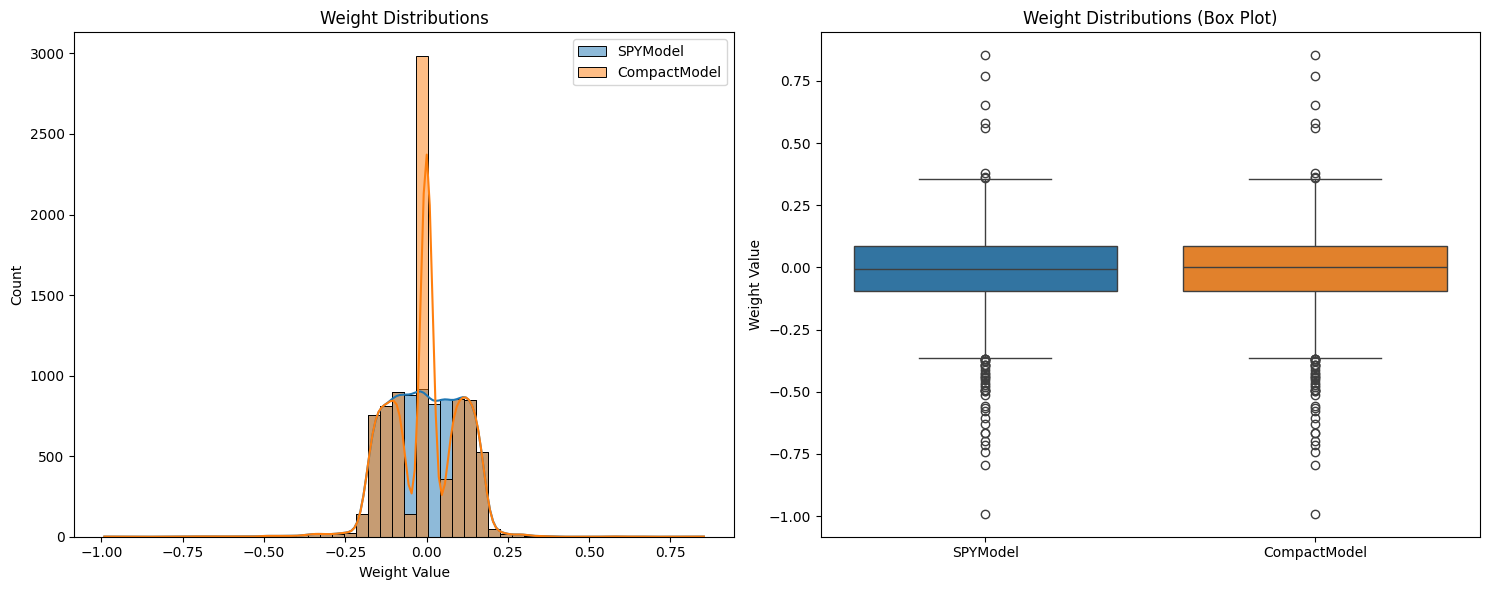


4. Performance Metrics:
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


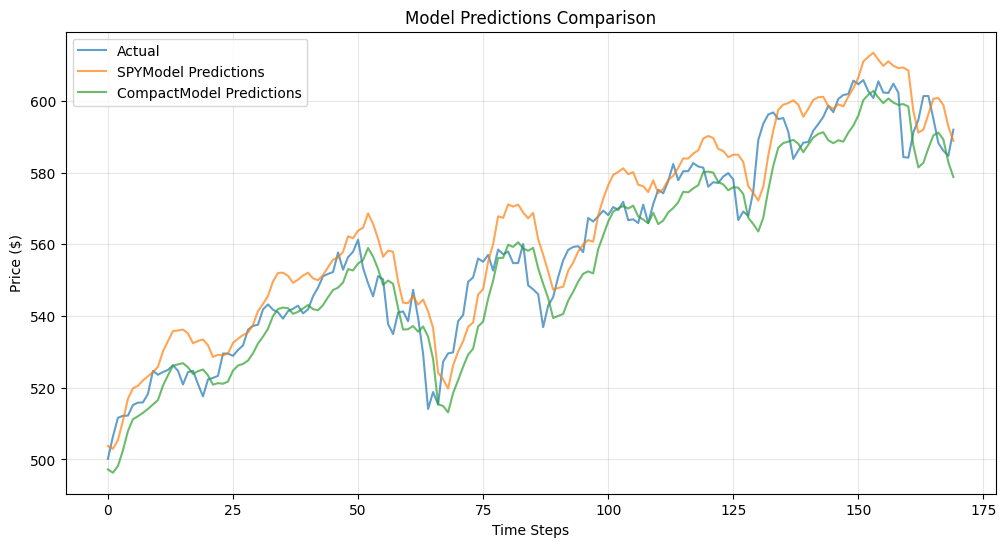

                    MSE      RMSE       MAE        R2
SPYModel      91.444878  9.562682  7.735817  0.876112
CompactModel  75.170326  8.670082  6.779068  0.898160


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

class ModelComparator:
    def __init__(self, model1_path, model2_path, model1_name="Model 1", model2_name="Model 2"):
        """
        Initialize ModelComparator with paths to two Keras models.

        Args:
            model1_path (str): Path to first model
            model2_path (str): Path to second model
            model1_name (str): Name for first model
            model2_name (str): Name for second model
        """
        self.model1 = load_model(model1_path)
        self.model2 = load_model(model2_path)
        self.model1_name = model1_name
        self.model2_name = model2_name

    def compare_architectures(self):
        """Compare layer architectures of both models."""
        comparison = []

        # Get maximum number of layers between both models
        max_layers = max(len(self.model1.layers), len(self.model2.layers))

        for i in range(max_layers):
            layer1 = self.model1.layers[i] if i < len(self.model1.layers) else None
            layer2 = self.model2.layers[i] if i < len(self.model2.layers) else None

            layer_info = {
                'Layer Index': i,
                f'{self.model1_name} Layer': layer1.__class__.__name__ if layer1 else 'N/A',
                f'{self.model1_name} Output Shape': str(layer1.output_shape) if layer1 else 'N/A',
                f'{self.model2_name} Layer': layer2.__class__.__name__ if layer2 else 'N/A',
                f'{self.model2_name} Output Shape': str(layer2.output_shape) if layer2 else 'N/A'
            }
            comparison.append(layer_info)

        return pd.DataFrame(comparison)

    def compare_parameters(self):
        """Compare parameter counts between models."""
        def get_param_details(model):
            trainable_params = sum([layer.count_params() for layer in model.layers])
            non_trainable_params = sum([np.sum([K.count_params(p) for p in layer.non_trainable_weights])
                                     for layer in model.layers])
            return {
                'Total Parameters': trainable_params + non_trainable_params,
                'Trainable Parameters': trainable_params,
                'Non-trainable Parameters': non_trainable_params
            }

        model1_params = get_param_details(self.model1)
        model2_params = get_param_details(self.model2)

        comparison = pd.DataFrame({
            self.model1_name: model1_params,
            self.model2_name: model2_params
        }).T

        return comparison

    def compare_weights_distribution(self):
        """Compare weight distributions between models."""
        plt.figure(figsize=(15, 6))

        # Collect all weights
        weights1 = np.concatenate([layer.get_weights()[0].flatten()
                                 for layer in self.model1.layers
                                 if len(layer.get_weights()) > 0])
        weights2 = np.concatenate([layer.get_weights()[0].flatten()
                                 for layer in self.model2.layers
                                 if len(layer.get_weights()) > 0])

        # Plot distributions
        plt.subplot(1, 2, 1)
        sns.histplot(weights1, bins=50, kde=True, label=self.model1_name)
        sns.histplot(weights2, bins=50, kde=True, label=self.model2_name)
        plt.title('Weight Distributions')
        plt.xlabel('Weight Value')
        plt.ylabel('Count')
        plt.legend()

        # Plot box plots
        plt.subplot(1, 2, 2)
        data = {
            self.model1_name: weights1,
            self.model2_name: weights2
        }
        sns.boxplot(data=data)
        plt.title('Weight Distributions (Box Plot)')
        plt.ylabel('Weight Value')

        plt.tight_layout()
        plt.show()

    def compare_predictions(self, X_test, y_test, scaler):
        """
        Compare model predictions and performance metrics.

        Args:
            X_test: Test input data
            y_test: True test values
            scaler: Fitted scaler object for inverse transformation
        """
        # Get predictions
        pred1 = self.model1.predict(X_test)
        pred2 = self.model2.predict(X_test)

        # Inverse transform if scaler provided
        if scaler:
            y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
            pred1 = scaler.inverse_transform(pred1)
            pred2 = scaler.inverse_transform(pred2)

        # Calculate metrics
        metrics = {
            self.model1_name: {
                'MSE': mean_squared_error(y_test, pred1),
                'RMSE': np.sqrt(mean_squared_error(y_test, pred1)),
                'MAE': mean_absolute_error(y_test, pred1),
                'R2': r2_score(y_test, pred1)
            },
            self.model2_name: {
                'MSE': mean_squared_error(y_test, pred2),
                'RMSE': np.sqrt(mean_squared_error(y_test, pred2)),
                'MAE': mean_absolute_error(y_test, pred2),
                'R2': r2_score(y_test, pred2)
            }
        }

        # Plot predictions
        plt.figure(figsize=(12, 6))
        plt.plot(y_test, label='Actual', alpha=0.7)
        plt.plot(pred1, label=f'{self.model1_name} Predictions', alpha=0.7)
        plt.plot(pred2, label=f'{self.model2_name} Predictions', alpha=0.7)
        plt.title('Model Predictions Comparison')
        plt.xlabel('Time Steps')
        plt.ylabel('Price ($)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        return pd.DataFrame(metrics).T

    def generate_report(self, X_test=None, y_test=None, scaler=None):
        """Generate comprehensive comparison report."""
        print(f"Model Comparison Report: {self.model1_name} vs {self.model2_name}")
        print("\n1. Architecture Comparison:")
        #print(self.compare_architectures().to_string())

        print("\n2. Parameter Comparison:")
        print(self.compare_parameters().to_string())

        print("\n3. Weight Distribution:")
        self.compare_weights_distribution()

        if X_test is not None and y_test is not None:
            print("\n4. Performance Metrics:")
            print(self.compare_predictions(X_test, y_test, scaler).to_string())
# Fetch and process data
data = fetch_data()
X, y, scaler = process_data(data)

# Split data into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize comparator with your model paths
comparator = ModelComparator(
    '/content/spy_predictor_model.keras',
    '/content/compact_model.keras',
    model1_name="SPYModel",
    model2_name="CompactModel"
)

# Generate comprehensive comparison report
comparator.generate_report(X_test, y_test, scaler)

In [ ]:
pip install psutil

Starting benchmark comparison...
Testing models: ['/content/compact_model.keras', '/content/spy_predictor_model.keras']
Data sizes: [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000] days

Testing dataset size: 1000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 0.21 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.52 MB
Memory after predictions: 0.69 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.02 MB

Testing dataset size: 1500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 0.38 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -0.01 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB


[*********************100%***********************]  1 of 1 completed


Testing dataset size: 2000 days


Memory after data fetch: 0.67 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB


[*********************100%***********************]  1 of 1 completed


Testing dataset size: 2500 days


Memory after data fetch: 0.52 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -0.01 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing dataset size: 3000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 0.87 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -31.00 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.51 MB
Memory after predictions: 0.75 MB

Testing dataset size: 3500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.08 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.48 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.07 MB


[*********************100%***********************]  1 of 1 completed


Testing dataset size: 4000 days


Memory after data fetch: 1.23 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.51 MB
Memory after predictions: 1.04 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.05 MB

Testing dataset size: 4500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.37 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.32 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.09 MB


[*********************100%***********************]  1 of 1 completed


Testing dataset size: 5000 days


Memory after data fetch: 1.72 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.29 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.13 MB

Testing dataset size: 5500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.39 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: -5.90 MB
Memory after predictions: -4.05 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.25 MB
Memory after predictions: 0.53 MB

Testing dataset size: 6000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 0.92 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.48 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.30 MB

Testing dataset size: 6500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.73 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.64 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.01 MB

Testing dataset size: 7000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.84 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.16 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.32 MB

Testing dataset size: 7500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.66 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.66 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -3.20 MB

Testing dataset size: 8000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 2.23 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.52 MB
Memory after predictions: 1.19 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.03 MB

Testing dataset size: 8500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 2.16 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.36 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.25 MB
Memory after predictions: 0.70 MB

Testing dataset size: 9000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 2.09 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.72 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.25 MB
Memory after predictions: 0.72 MB

Testing dataset size: 9500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.91 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.61 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.65 MB

Testing dataset size: 10000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.93 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 1.14 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.25 MB
Memory after predictions: 1.10 MB

Testing dataset size: 10500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.82 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -4.35 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.25 MB
Memory after predictions: 0.77 MB

Testing dataset size: 11000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 2.63 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 1.24 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.82 MB

Testing dataset size: 11500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.28 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.41 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.70 MB

Testing dataset size: 12000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.57 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 1.03 MB
Memory after model load: 1.03 MB
Memory after predictions: 1.27 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.43 MB

Testing dataset size: 12500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.67 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.01 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing dataset size: 13000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 2.61 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: -5.49 MB
Memory after predictions: -3.70 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.07 MB

Testing dataset size: 13500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.78 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.02 MB

Testing dataset size: 14000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.18 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.01 MB

Testing dataset size: 14500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 1.66 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -0.01 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.01 MB

Testing dataset size: 15000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 3.34 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -0.01 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -5.28 MB

Testing dataset size: 15500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 3.95 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.26 MB
Memory after model load: 0.26 MB
Memory after predictions: 0.79 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.07 MB

Testing dataset size: 16000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 2.27 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.14 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing dataset size: 16500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 0.90 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.02 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing dataset size: 17000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 0.89 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -0.01 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing dataset size: 17500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 0.22 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -0.01 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -5.08 MB

Testing dataset size: 18000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 0.61 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.43 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.09 MB

Testing dataset size: 18500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 2.14 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -0.00 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.01 MB

Testing dataset size: 19000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 0.79 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.27 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing dataset size: 19500 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 0.29 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -0.00 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.00 MB

Testing dataset size: 20000 days


[*********************100%***********************]  1 of 1 completed


Memory after data fetch: 0.90 MB

Testing model: /content/compact_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: 0.02 MB

Testing model: /content/spy_predictor_model.keras
------------------------------
Memory after data processing: 0.00 MB
Memory after model load: 0.00 MB
Memory after predictions: -6.28 MB

Benchmark Results:
                                 model  data_size  execution_time  peak_memory_mb  final_memory_mb  baseline_memory_mb       mse      mae  samples_processed
0         /content/compact_model.keras       1000            0.89          784.78           784.78              784.09   45.9431   5.2039                672
1   /content/spy_predictor_model.keras       1000            1.18          784.80           784.80              784.78   63.3148   6.3256                672
2         /content/compact_model.keras       1500            1.09          785.18           785.17         

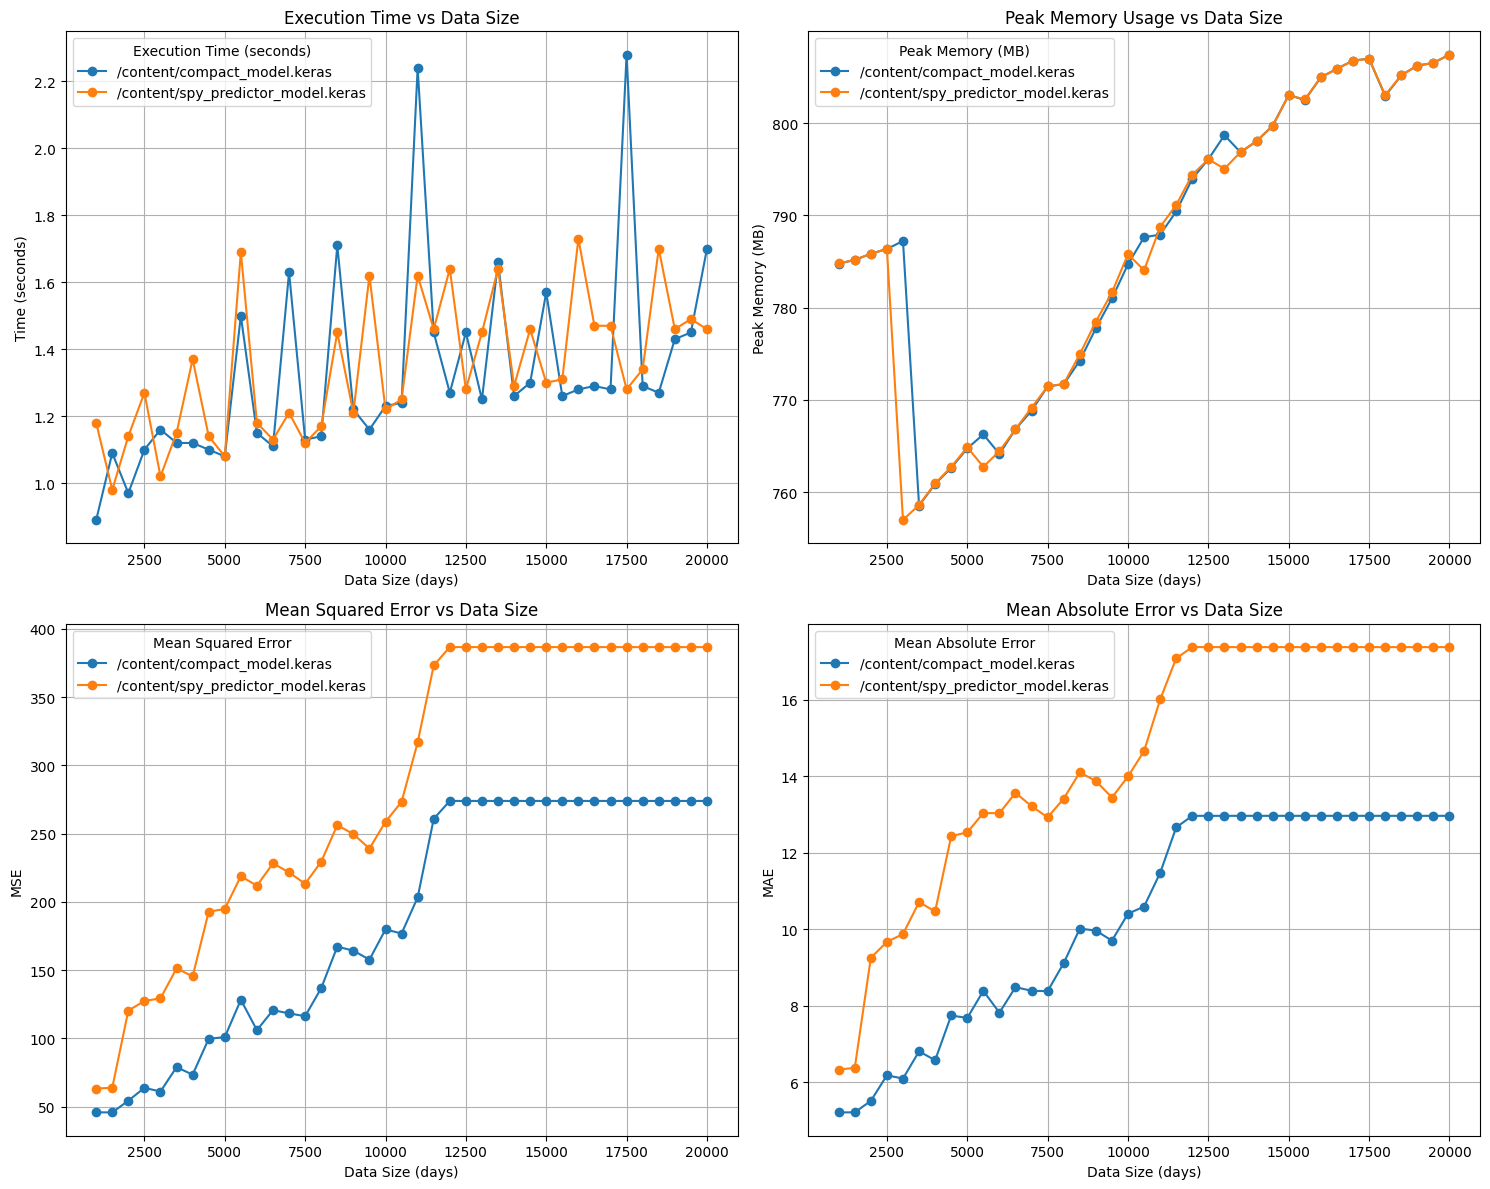

Saved execution_time data to benchmark_results_execution_time.csv
Saved peak_memory data to benchmark_results_peak_memory.csv
Saved mean_squared_error data to benchmark_results_mean_squared_error.csv
Saved mean_absolute_error data to benchmark_results_mean_absolute_error.csv

Memory Usage Summary:

Model: /content/compact_model.keras
Peak Memory: 807.45 MB
Average Memory: 787.47 MB

Model: /content/spy_predictor_model.keras
Peak Memory: 807.45 MB
Average Memory: 786.58 MB


In [ ]:
import time
import psutil
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from datetime import datetime, timedelta
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import gc
import os
import tensorflow as tf

class MemoryTracker:
    def __init__(self):
        self.peak_memory = 0
        self.current_memory = 0
        self.baseline = self._get_current_memory()

    def _get_current_memory(self):
        """Get current memory usage in MB"""
        gc.collect()
        process = psutil.Process(os.getpid())
        memory = process.memory_info().rss / 1024 / 1024
        return memory

    def update(self):
        """Update memory tracking"""
        current = self._get_current_memory()
        self.current_memory = current
        self.peak_memory = max(self.peak_memory, current)
        return current - self.baseline

    def get_stats(self):
        """Get memory statistics"""
        return {
            'current': round(self.current_memory, 2),
            'peak': round(self.peak_memory, 2),
            'baseline': round(self.baseline, 2)
        }

def benchmark_models(model_paths, data_sizes, lookback=14, gap=1):
    """
    Benchmark multiple models with different data sizes.

    Args:
        model_paths (list): List of paths to saved Keras models
        data_sizes (list): List of lookback days to test
        lookback (int): Lookback window size for predictions
        gap (int): Prediction gap

    Returns:
        pd.DataFrame: Benchmark results
    """
    results = []

    for size in data_sizes:
        print(f"\nTesting dataset size: {size} days")
        print("=" * 50)

        # Initialize memory tracker for this dataset
        memory_tracker = MemoryTracker()

        # Fetch larger dataset
        data = fetch_data(lookback_days=size)
        memory_after_fetch = memory_tracker.update()
        print(f"Memory after data fetch: {memory_after_fetch:.2f} MB")

        for model_path in model_paths:
            print(f"\nTesting model: {model_path}")
            print("-" * 30)

            try:
                # Reset memory tracker for each model
                memory_tracker = MemoryTracker()

                # Start timing
                start_time = time.time()

                # Process data
                X, y, scaler = process_data(data, lookback, gap)
                memory_after_processing = memory_tracker.update()
                print(f"Memory after data processing: {memory_after_processing:.2f} MB")

                # Load model
                model = load_model(model_path)
                memory_after_load = memory_tracker.update()
                print(f"Memory after model load: {memory_after_load:.2f} MB")

                # Make predictions
                predictions = model.predict(X, verbose=0)
                memory_after_predict = memory_tracker.update()
                print(f"Memory after predictions: {memory_after_predict:.2f} MB")

                # Calculate metrics
                end_time = time.time()

                # Calculate prediction accuracy
                actual_prices = scaler.inverse_transform(y.reshape(-1, 1))
                predicted_prices = scaler.inverse_transform(predictions)
                mse = np.mean((actual_prices - predicted_prices) ** 2)
                mae = np.mean(np.abs(actual_prices - predicted_prices))

                # Get final memory stats
                memory_stats = memory_tracker.get_stats()

                results.append({
                    'model': model_path,
                    'data_size': size,
                    'execution_time': round(end_time - start_time, 2),
                    'peak_memory_mb': memory_stats['peak'],
                    'final_memory_mb': memory_stats['current'],
                    'baseline_memory_mb': memory_stats['baseline'],
                    'mse': round(mse, 4),
                    'mae': round(mae, 4),
                    'samples_processed': len(X)
                })

                # Clean up
                del model, X, y, scaler, predictions
                gc.collect()

            except Exception as e:
                print(f"Error processing model {model_path}: {str(e)}")
                continue

            # Final memory cleanup
            gc.collect()

    return pd.DataFrame(results)

def plot_benchmark_results(results):
    """
    Plot benchmark results.

    Args:
        results (pd.DataFrame): Benchmark results DataFrame
    """
    if len(results) == 0:
        print("No results to plot!")
        return

    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Plot execution time
    for model in results['model'].unique():
        model_data = results[results['model'] == model]
        ax1.plot(model_data['data_size'], model_data['execution_time'],
                marker='o', label=f'Model: {model}')
    ax1.set_title('Execution Time vs Data Size')
    ax1.set_xlabel('Data Size (days)')
    ax1.set_ylabel('Time (seconds)')
    ax1.legend()
    ax1.grid(True)

    # Plot peak memory usage
    for model in results['model'].unique():
        model_data = results[results['model'] == model]
        ax2.plot(model_data['data_size'], model_data['peak_memory_mb'],
                marker='o', label=f'Model: {model}')
    ax2.set_title('Peak Memory Usage vs Data Size')
    ax2.set_xlabel('Data Size (days)')
    ax2.set_ylabel('Peak Memory (MB)')
    ax2.legend()
    ax2.grid(True)

    # Plot MSE
    for model in results['model'].unique():
        model_data = results[results['model'] == model]
        ax3.plot(model_data['data_size'], model_data['mse'],
                marker='o', label=f'Model: {model}')
    ax3.set_title('Mean Squared Error vs Data Size')
    ax3.set_xlabel('Data Size (days)')
    ax3.set_ylabel('MSE')
    ax3.legend()
    ax3.grid(True)

    # Plot MAE
    for model in results['model'].unique():
        model_data = results[results['model'] == model]
        ax4.plot(model_data['data_size'], model_data['mae'],
                marker='o', label=f'Model: {model}')
    ax4.set_title('Mean Absolute Error vs Data Size')
    ax4.set_xlabel('Data Size (days)')
    ax4.set_ylabel('MAE')
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    plt.show()

def run_benchmark_comparison(model_paths, data_sizes=[1250, 2500, 5000]):
    """
    Run complete benchmark comparison for multiple models.

    Args:
        model_paths (list): List of paths to saved Keras models
        data_sizes (list): List of lookback days to test
    """
    print("Starting benchmark comparison...")
    print(f"Testing models: {model_paths}")
    print(f"Data sizes: {data_sizes} days")

    # Run benchmarks
    results = benchmark_models(model_paths, data_sizes)

    if len(results) > 0:
        # Display results
        print("\nBenchmark Results:")
        print(results.to_string())

        # Plot results
        plot_benchmark_results(results)

        # Print summary statistics
        print("\nMemory Usage Summary:")
        for model in results['model'].unique():
            model_data = results[results['model'] == model]
            print(f"\nModel: {model}")
            print(f"Peak Memory: {model_data['peak_memory_mb'].max():.2f} MB")
            print(f"Average Memory: {model_data['peak_memory_mb'].mean():.2f} MB")
    else:
        print("No results were generated. Please check your model paths and data sizes.")

    return results


def prepare_plot_data(results):
    """
    Prepare plot data in a format suitable for CSV export.

    Args:
        results (pd.DataFrame): Benchmark results DataFrame

    Returns:
        dict: Dictionary of DataFrames for each metric
    """
    plot_data = {}

    # Prepare data for each metric
    metrics = {
        'execution_time': 'Execution Time (seconds)',
        'peak_memory_mb': 'Peak Memory (MB)',
        'mse': 'Mean Squared Error',
        'mae': 'Mean Absolute Error'
    }

    for metric, metric_name in metrics.items():
        # Create DataFrame with data_size as index and models as columns
        df = pd.pivot_table(
            results,
            values=metric,
            index='data_size',
            columns='model',
            aggfunc='first'
        )
        df.index.name = 'Data Size (days)'
        df.columns.name = metric_name
        plot_data[metric] = df

    return plot_data

def export_plot_data(plot_data, base_filename='benchmark_results'):
    """
    Export plot data to CSV files.

    Args:
        plot_data (dict): Dictionary of DataFrames for each metric
        base_filename (str): Base filename for CSV files
    """
    metric_names = {
        'execution_time': 'execution_time',
        'peak_memory_mb': 'peak_memory',
        'mse': 'mean_squared_error',
        'mae': 'mean_absolute_error'
    }

    for metric, name in metric_names.items():
        filename = f"{base_filename}_{name}.csv"
        plot_data[metric].to_csv(filename)
        print(f"Saved {name} data to {filename}")

def plot_benchmark_results(results):
    """
    Plot benchmark results and return plot data.

    Args:
        results (pd.DataFrame): Benchmark results DataFrame

    Returns:
        dict: Dictionary containing the plot data
    """
    if len(results) == 0:
        print("No results to plot!")
        return {}

    # Prepare plot data
    plot_data = prepare_plot_data(results)

    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Plot execution time
    plot_data['execution_time'].plot(ax=ax1, marker='o')
    ax1.set_title('Execution Time vs Data Size')
    ax1.set_xlabel('Data Size (days)')
    ax1.set_ylabel('Time (seconds)')
    ax1.grid(True)

    # Plot peak memory usage
    plot_data['peak_memory_mb'].plot(ax=ax2, marker='o')
    ax2.set_title('Peak Memory Usage vs Data Size')
    ax2.set_xlabel('Data Size (days)')
    ax2.set_ylabel('Peak Memory (MB)')
    ax2.grid(True)

    # Plot MSE
    plot_data['mse'].plot(ax=ax3, marker='o')
    ax3.set_title('Mean Squared Error vs Data Size')
    ax3.set_xlabel('Data Size (days)')
    ax3.set_ylabel('MSE')
    ax3.grid(True)

    # Plot MAE
    plot_data['mae'].plot(ax=ax4, marker='o')
    ax4.set_title('Mean Absolute Error vs Data Size')
    ax4.set_xlabel('Data Size (days)')
    ax4.set_ylabel('MAE')
    ax4.grid(True)

    plt.tight_layout()
    plt.show()

    return plot_data

def run_benchmark_comparison(model_paths, data_sizes=[ 1000,  1500,  2000,  2500,  3000,  3500,  4000,  4500,  5000, 5500,  6000,  6500,  7000,  7500,  8000,  8500,  9000,  9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000], export_csv=True):
    """
    Run complete benchmark comparison for multiple models.

    Args:
        model_paths (list): List of paths to saved Keras models
        data_sizes (list): List of lookback days to test
        export_csv (bool): Whether to export plot data to CSV files

    Returns:
        tuple: (results DataFrame, plot data dictionary)
    """
    print("Starting benchmark comparison...")
    print(f"Testing models: {model_paths}")
    print(f"Data sizes: {data_sizes} days")

    # Run benchmarks
    results = benchmark_models(model_paths, data_sizes)

    if len(results) > 0:
        # Display results
        print("\nBenchmark Results:")
        print(results.to_string())

        # Plot results and get plot data
        plot_data = plot_benchmark_results(results)

        # Export plot data if requested
        if export_csv:
            export_plot_data(plot_data)

        # Print summary statistics
        print("\nMemory Usage Summary:")
        for model in results['model'].unique():
            model_data = results[results['model'] == model]
            print(f"\nModel: {model}")
            print(f"Peak Memory: {model_data['peak_memory_mb'].max():.2f} MB")
            print(f"Average Memory: {model_data['peak_memory_mb'].mean():.2f} MB")

        return results, plot_data
    else:
        print("No results were generated. Please check your model paths and data sizes.")
        return pd.DataFrame(), {}

# Example of how the plot data is structured
def print_plot_data_example(plot_data):
    """Print example of plot data structure"""
    print("\nPlot Data Structure Example:")
    for metric, df in plot_data.items():
        print(f"\n{metric} data:")
        print(df)


# List of model paths to compare
model_paths = ['/content/compact_model.keras', '/content/spy_predictor_model.keras']

# Run benchmark
results = run_benchmark_comparison(model_paths)


# compact model and spy predictor model grouped together by data size testing memory, excevution time and accuracy:`

| Data Size | Execution Time (Compact) | Execution Time (Spy) | Peak Memory (Compact) | Peak Memory (Spy) | Final Memory (Compact) | Final Memory (Spy) | MSE (Compact) | MSE (Spy) | MAE (Compact) | MAE (Spy) | Samples Processed |
|-----------|---------------------------|-----------------------|------------------------|--------------------|-------------------------|--------------------|---------------|-------------|----------------|------------|-------------------|
| 1000      | 0.89                      | 1.18                  | 784.78                 | 784.80             | 784.78                  | 784.80             | 45.9431       | 63.3148    | 5.2039         | 6.3256     | 672               |
| 1500      | 1.09                      | 0.98                  | 785.18                 | 785.18             | 785.17                  | 785.18             | 45.8036       | 63.9008    | 5.2083         | 6.3705     | 1016              |
| 2000      | 0.97                      | 1.14                  | 785.85                 | 785.85             | 785.85                  | 785.85             | 54.4298       | 120.3989   | 5.5057         | 9.2488     | 1364              |
| 2500      | 1.10                      | 1.27                  | 786.37                 | 786.36             | 786.36                  | 786.36             | 63.8166       | 127.4107   | 6.1759         | 9.6651     | 1707              |
| 3000      | 1.16                      | 1.02                  | 787.23                 | 756.98             | 756.23                  | 756.98             | 61.1390       | 129.3714   | 6.0906         | 9.8708     | 2051              |
| 3500      | 1.12                      | 1.15                  | 758.54                 | 758.61             | 758.54                  | 758.61             | 78.9565       | 151.3001   | 6.8020         | 10.7051    | 2396              |
| 4000      | 1.12                      | 1.37                  | 760.89                 | 760.94             | 760.89                  | 760.94             | 73.4839       | 145.4485   | 6.5707         | 10.4622    | 2742              |
| 4500      | 1.10                      | 1.14                  | 762.63                 | 762.73             | 762.63                  | 762.73             | 99.7408       | 192.8556   | 7.7404         | 12.4318    | 3084              |
| 5000      | 1.08                      | 1.08                  | 764.74                 | 764.87             | 764.74                  | 764.87             | 100.9779      | 194.7816   | 7.6756         | 12.5317    | 3429              |
| 5500      | 1.50                      | 1.69                  | 766.26                 | 762.74             | 762.21                  | 762.74             | 128.2782      | 218.8080   | 8.3846         | 13.0354    | 3774              |
| 6000      | 1.15                      | 1.18                  | 764.14                 | 764.44             | 764.14                  | 764.44             | 106.0793      | 211.8249   | 7.8129         | 13.0321    | 4119              |
| 6500      | 1.11                      | 1.13                  | 766.82                 | 766.83             | 766.82                  | 766.83             | 120.7013      | 228.2689   | 8.4821         | 13.5645    | 4465              |
| 7000      | 1.63                      | 1.21                  | 768.83                 | 769.15             | 768.83                  | 769.15             | 118.3627      | 221.5259   | 8.3864         | 13.2150    | 4806              |
| 7500      | 1.13                      | 1.12                  | 771.47                 | 771.47             | 771.47                  | 768.28             | 116.2947      | 213.2701   | 8.3770         | 12.9232    | 5154              |
| 8000      | 1.14                      | 1.17                  | 771.70                 | 771.73             | 771.70                  | 771.73             | 136.8510      | 229.4331   | 9.1104         | 13.4131    | 5498              |
| 8500      | 1.71                      | 1.45                  | 774.25                 | 774.95             | 774.25                  | 774.95             | 167.2012      | 256.2408   | 10.0120        | 14.0998    | 5842              |
| 9000      | 1.22                      | 1.21                  | 777.76                 | 778.48             | 777.04                  | 778.48             | 164.3347      | 249.6241   | 9.9619         | 13.8743    | 6184              |
| 9500      | 1.16                      | 1.62                  | 781.00                 | 781.65             | 780.39                  | 781.65             | 157.6918      | 239.0407   | 9.6975         | 13.4419    | 6528              |
| 10000     | 1.23                      | 1.22                  | 784.71                 | 785.81             | 783.58                  | 785.81             | 179.8278      | 258.6669   | 10.4029        | 13.9918    | 6874              |
| 10500     | 1.24                      | 1.25                  | 787.64                 | 784.06             | 783.29                  | 784.06             | 176.8352      | 273.2633   | 10.5895        | 14.6566    | 7220              |
| 11000     | 2.24                      | 1.62                  | 787.93                 | 788.76             | 786.69                  | 788.76             | 203.2641      | 316.7749   | 11.4700        | 16.0059    | 7565              |
| 11500     | 1.45                      | 1.46                  | 790.44                 | 791.14             | 790.04                  | 791.14             | 260.8388      | 373.1126   | 12.6617        | 17.0845    | 7913              |
| 12000     | 1.27                      | 1.64                  | 793.99                 | 794.42             | 792.72                  | 794.42             | 273.9220      | 386.5691   | 12.9628        | 17.3764    | 8025              |
| 12500     | 1.45                      | 1.28                  | 796.10                 | 796.10             | 796.09                  | 796.10             | 273.9221      | 386.5691   | 12.9628        | 17.3764    | 8025              |
| 13000     | 1.25                      | 1.45                  | 798.71                 | 795.07             | 795.00                  | 795.07             | 273.9220      | 386.5691   | 12.9628        | 17.3764    | 8025              |
| 13500     | 1.66                      | 1.64                  | 796.86                 | 796.87             | 796.86                  | 796.87             | 273.9219      | 386.5691   | 12.9628        | 17.3764    | 8025              |
| 14000     | 1.26                      | 1.29                  | 798.06                 | 798.07             | 798.05                  | 798.07             | 273.9221      | 386.5692   | 12.9628        | 17.3764    | 8025              |
| 14500     | 1.30                      | 1.46                  | 799.73                 | 799.73             | 799.71                  | 799.73             | 273.9220      | 386.5692   | 12.9628        | 17.3764    | 8025              |
| 15000     | 1.57                      | 1.30                  | 803.07                 | 803.05             | 803.05                  | 797.78             | 273.9220      | 386.5691   | 12.9628        | 17.3764    | 8025              |
| 15500     | 1.26                      | 1.31                  | 802.52                 | 802.59             | 801.73                  | 802.59             | 273.9219      | 386.5690   | 12.9628        | 17.3764    | 8025              |
| 16000     | 1.28                      | 1.73                  | 804.99                 | 804.99             | 804.85                  | 804.99             | 273.9220      | 386.5691   | 12.9628        | 17.3764    | 8025              |
| 16500     | 1.29                      | 1.47                  | 805.91                 | 805.91             | 805.89                  | 805.91             | 273.9220      | 386.5691   | 12.9628        | 17.3764    | 8025              |
| 17000     | 1.28                      | 1.47                  | 806.80                 | 806.79             | 806.79                  | 806.79             | 273.9220      | 386.5691   | 12.9628        | 17.3764    | 8025              |
| 17500     | 2.28                      | 1.28                  | 807.01                 | 807.00             | 807.00                  | 801.92             | 273.9221      | 386.5692   | 12.9628        | 17.3764    | 8025              |
| 18000     | 1.29                      | 1.34                  | 802.96                 | 803.05             | 802.53                  | 803.05             | 273.9220      | 386.5691   | 12.9628        | 17.3764    | 8025              |
| 18500     | 1.27                      | 1.70                  | 805.20                 | 805.20             | 805.19                  | 805.20             | 273.9219      | 386.5691   | 12.9628        | 17.3764    | 8025              |
| 19000     | 1.43                      | 1.46                  | 806.26                 | 806.26             | 805.99                  | 806.26             | 273.9221      | 386.5691   | 12.9628        | 17.3764    | 8025              |
| 19500     | 1.45                      | 1.49                  | 806.54                 | 806.54             | 806.54                  | 806.54             | 273.9220      | 386.5692   | 12.9628        | 17.3764    | 8025              |
| 20000     | 1.70                      | 1.46                  | 807.45                 | 807.45             | 807.44                  | 801.17             | 273.9221      | 386.5691   | 12.9628        | 17.3764    | 8025              |

---

